# FINAL DRAFT OF THIS 
Inputs: cdom files 
outputs: wavelenths.csv, plot.png, outputs.csv
    
    redesinge from inputs 
    
    Hanna Bridgham 
    last edited 11/17/2022

## PART 1: QA/QC

Loading data and checking for issues 

In [1]:
#LOAD REQUIERD PACKAGES 
import os # OS library
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names

from scipy.interpolate import PchipInterpolator # Interpolator
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [2]:
files = glob.glob('../../../IRL22SU/CDOM/ABS*/2*.txt')
pathlength = .01
psu = 0
ylimmin = -.5
ylimmax = 5
files.sort()
print('I have your files')
files

I have your files


['../../../IRL22SU/CDOM\\ABS_PW_IRL_2271_1cm\\227121_Absorbance_01.txt',
 '../../../IRL22SU/CDOM\\ABS_PW_IRL_2271_1cm\\227121_Absorbance_02.txt',
 '../../../IRL22SU/CDOM\\ABS_PW_IRL_2271_1cm\\227121_Absorbance_03.txt',
 '../../../IRL22SU/CDOM\\ABS_PW_IRL_2271_1cm\\227122_Absorbance_01.txt',
 '../../../IRL22SU/CDOM\\ABS_PW_IRL_2271_1cm\\227122_Absorbance_02.txt',
 '../../../IRL22SU/CDOM\\ABS_PW_IRL_2271_1cm\\227122_Absorbance_03.txt',
 '../../../IRL22SU/CDOM\\ABS_PW_IRL_2271_1cm\\227123_Absorbance_01.txt',
 '../../../IRL22SU/CDOM\\ABS_PW_IRL_2271_1cm\\227123_Absorbance_02.txt',
 '../../../IRL22SU/CDOM\\ABS_PW_IRL_2271_1cm\\227123_Absorbance_03.txt',
 '../../../IRL22SU/CDOM\\ABS_PW_IRL_2271_1cm\\227125_Absorbance_01.txt',
 '../../../IRL22SU/CDOM\\ABS_PW_IRL_2271_1cm\\227125_Absorbance_02.txt',
 '../../../IRL22SU/CDOM\\ABS_PW_IRL_2271_1cm\\227125_Absorbance_03.txt',
 '../../../IRL22SU/CDOM\\ABS_PW_IRL_2271_1cm\\227126_Absorbance_01.txt',
 '../../../IRL22SU/CDOM\\ABS_PW_IRL_2271_1cm\\22712

In [3]:
# REMOVE THIS CELL ONE YOU GET IT
ID = os.path.basename(files[-1])[:-4].split("_")
#ID = os.path.basename(files[-24])[:-4].split("_")
print('basename. SO indep. Extract filename:', ID)
ID = list(filter(None, ID))
# '_'.join(ID[::3])
ID.pop(1)
print('pop removes position 1', ID)
ID = '_'.join(ID)
print("")
print("here is an example:")
print(ID)
# ID = '_'.join(ID.remove('Absorbance'))
# ID

basename. SO indep. Extract filename: ['227106', 'Absorbance', '03']
pop removes position 1 ['227106', '03']

here is an example:
227106_03


In [4]:
#LOAD FILE
def open_files(name):
    # reads individual scan files
    df = pd.read_table(name, skiprows=14,names=['wl', 'abs'], index_col='wl')
    # extract ID from filename
    ID = os.path.basename(name)[:-4].split("_")
    ID.pop(1)
    ID = '_'.join(list(filter(None, ID)))
    # rename col name with ID
    df = df.rename(columns={'abs': ID})
    return df

#LOOP TRU FILES TO MAKE ONE EASY TO USE DATA FRAME 
#columns are scanns and rows are wavelths 

frames = [open_files(f) for f in files]
df = pd.concat(frames, axis=1) # joins along cols  

print("files loaded :)")

files loaded :)


graphs showing all the scanns for each sample


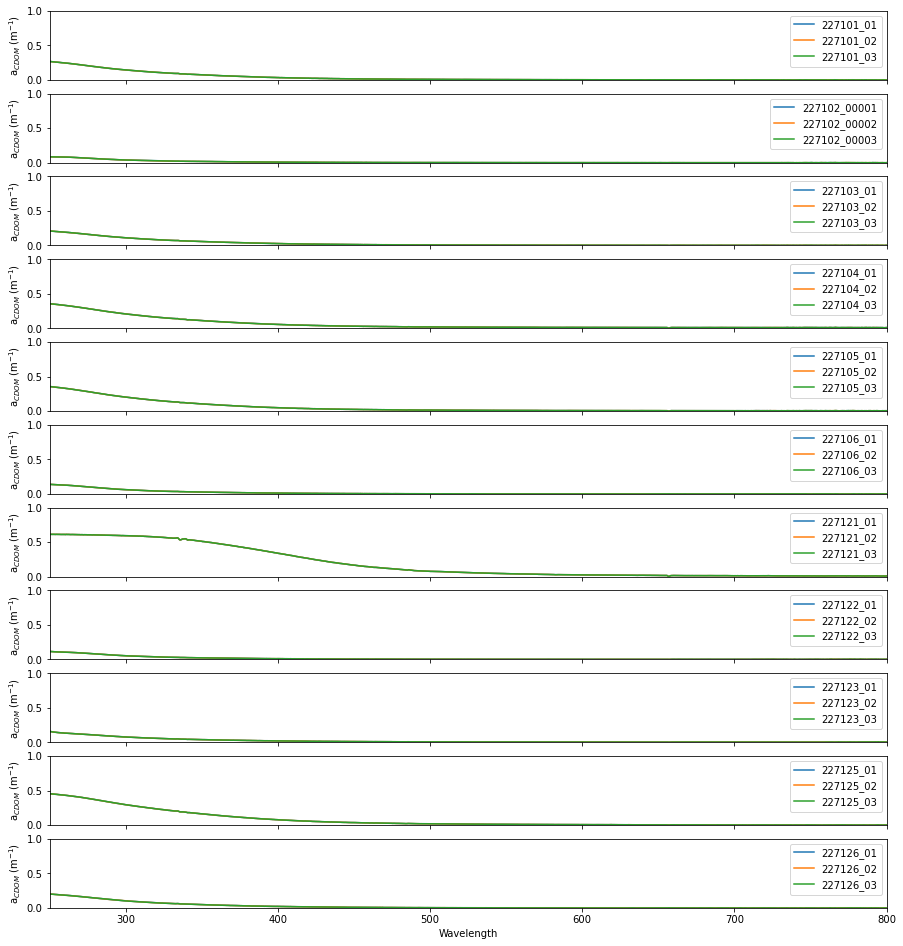

In [5]:
# Plot per sample
# First portion of col name is sample name
names = [name[0] for name in df.columns.str.rsplit('_')]
week_grps = df.groupby(names, axis = 1)
fig, axs = plt.subplots(nrows=len(week_grps), figsize=(15,1.5*len(week_grps)),
                       sharex=True, sharey=True)
for ax,(i, sub) in zip(axs, week_grps):
    sub.plot(label='', ax=ax)
    ax.set_ylim(0,1)
    ax.set_xlim(250,800)
    ax.set_ylabel("a$_{CDOM}$ (m$^{-1}$)")
axs[-1].set_xlabel("Wavelength")

print("graphs showing all the scanns for each sample")

In [6]:
#TEST AND REMOVE BAD SCANNS  
# Number of standard deviation that defines 'outlier'.
var = 2.5

z = df[250:700].groupby(names, axis = 1).transform(lambda grp: (grp - grp.mean())/grp.std())

test = z.abs().mean(skipna=True)<var
test = test[test==False] # Just print the bad ones

# DROP THE BAD FILES!!!!
df_clean = df.drop(columns=test.index) # drop bad scans

test 
rem = len(df.columns) - len(df_clean.columns)

print(rem, "sample scanns were removed")

0 sample scanns were removed


In [7]:
#df_clean = df

## PART 2: CORRECTING THE DATA 

- Absorbace to absorption 

- Salinity coorection 

- Temprature correction 

### Absorbance to absortion

absortion = absorbance*(2.303/pathlength)

graph showing the cdom Absortion data


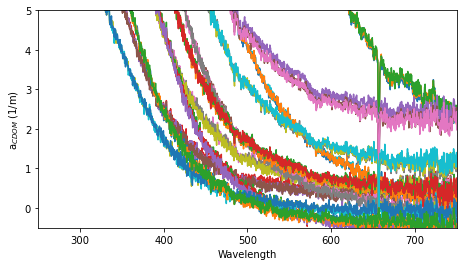

In [8]:
#Absorbance to Absortion
df_cl = df_clean*(2.303/pathlength) # to avoid overwriting when reruning the cell
df_cl

#make a plot to make sure nothing is too crazy 

fig, ax = plt.subplots(figsize=(7.5,4))
df_cl.plot(ax=ax, legend=None)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
print('graph showing the cdom Absortion data')

### Salinity correction

graph showing the interprolated correction


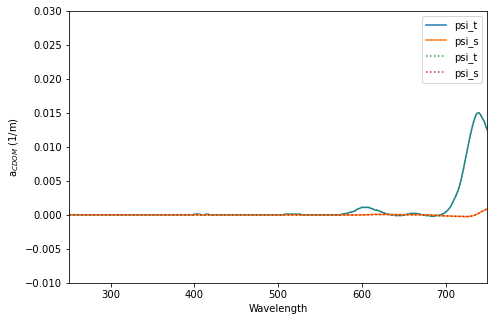

In [9]:
#HERE WE LOAD AND INTIGRATE THE CORRECTION VALUES 

#Load correction values 
df_c1 = df_clean*(2.303/pathlength)
corr = pd.read_csv('../../../CDOM_DATA/sal_temp_corr.csv')
corr.rename(columns={'wl_nm':'wl'}, inplace=True)
corr.set_index('wl', inplace=True)

# Interpolate corr curve to measured wl 
x = corr.index # corr wl
xi = df_c1[250:750].index # measured wl, no need to overwrite

#pchip temp  
y = corr['psi_t'] 
pchip_t = PchipInterpolator(x, y, axis=1)
psi_t = pchip_t(xi) 

#pchip salt 
y = corr['psi_s'] 
pchip_s = PchipInterpolator(x, y, axis=1)
psi_s = pchip_s(xi)

# to dataframe
correction = pd.DataFrame({'psi_t': psi_t, 'psi_s':psi_s}, index=xi)

# Plot
fig, ax = plt.subplots(figsize=(7.5,5))
corr.plot(ax=ax)
correction.plot(ls=':',ax=ax)
ax.set_ylim(-.01,.03)
ax.set_xlim(250,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
#ax.get_legend().remove() 

if corr.mean().mean()/correction.mean().mean() > .8: 
    print('graph showing the interprolated correction')
else:
    print('SOMETHING IS WRONG!')
    print('interprolated correction mean is less then 80%')
    print((corr.mean().mean()/correction.mean().mean())*100)

### Salinity correction
from sullivan 2006 

abs = abs_mesured - psu*psi_s 

Min val of clean data: -383.9101
Min val of salinity Corr: -1.05938
4.8872391632275525 % differance in mean values for clean to sal corrected
graph showing salinity corrected data


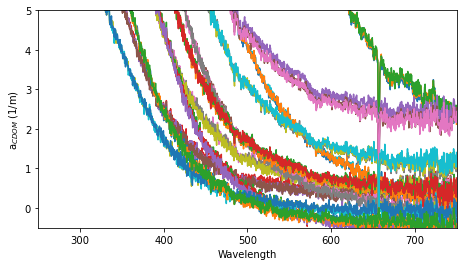

In [10]:
#HERE WE CORRECT FOR SALINITY 
#from sullivan 2006 
#a = a_m - psu*psi_s 

df_cs = df_cl[250:750].sub(psu*correction['psi_s'], axis=0)

fig, ax = plt.subplots(figsize=(7.5,4))
df_cs.plot(ax=ax, legend=None)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")

sal_corr_per = ((df_cl.mean().mean()-df_cs.mean().mean())/(df_cs.mean().mean()+df_cl.mean().mean())/2)*100

print("Min val of clean data:",df_cl.min().min()) 
print("Min val of salinity Corr:",df_cs.min().min()) 
print(sal_corr_per, "% differance in mean values for clean to sal corrected")

if df_cs.mean().mean()/df_cl.mean().mean() > .8: 
    print('graph showing salinity corrected data')
else:
    print('SOMETHING IS WRONG!')
    print('interprolated correction mean is less then 80%')
    print((df_cs.mean().mean()/df_cl.mean().mean())*100)

### Temperature correction
from sullivan 2006 

abs = abs_mesured - temp*psi_t 

In [11]:
#HERE WE DEFINE THE END AND DEFINE THE FUNTIONS 

#define the end section 
df_700 = df_cs[700:750] # df_cs is clean, abs and sal corrct aplied
temp_cor_700 = correction[700:750]['psi_t']       

#define temp correction 
def temp_cor(temp,
             c_abs, # the column
             t_cor= correction['psi_t']# the correction
            ):
    return (c_abs-t_cor*temp)

# this is the function to minimize the root mean squared 
def rmse(temp, col_abs):
    cor = temp_cor(temp, c_abs=col_abs, t_cor=correction[700:750]['psi_t'])
    col_abs_mean = col_abs.mean()
    col_resid = cor-col_abs_mean
    diff = np.sqrt(np.mean(col_resid**2))
    return  diff

print('funtions are defined')

funtions are defined


the test was a success! :) 


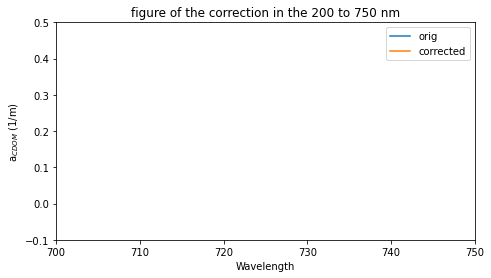

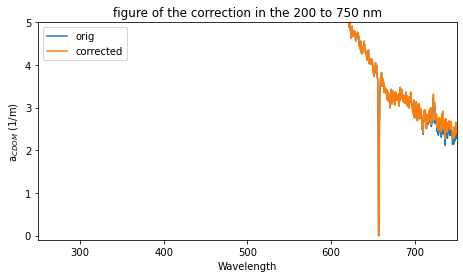

In [12]:
#HERE WE TEST THE TEMP CORRECTION FOR A COLUM 

#maybe play with bonds for improvement
#minimize(rmse, temp0, df_700.iloc[:,0], bounds=(min,max))

coln = 0

# for temp0 in range(-4,30):
res = minimize(rmse, -1, df_700.iloc[:,coln])
# Once a good minimization is found apply by column

# corrected column
col_ct = temp_cor(res.x, df_cs.iloc[:,coln])

# PLOTS
fig, ax = plt.subplots(figsize=(7.5,4))
df_cs.iloc[:,0].plot(ax=ax, label='orig')
col_ct.plot(ax=ax, label='corrected')
ax.set_ylim(-.1,.5)
ax.set_xlim(700,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("figure of the correction in the 200 to 750 nm")
ax.legend()
# df.min().min()

fig, ax = plt.subplots(figsize=(7.5,4))
df_cs.iloc[:,0].plot(ax=ax, label='orig')
col_ct.plot(ax=ax, label='corrected')
ax.set_ylim(-.1,5)
ax.set_xlim(250,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("figure of the correction in the 200 to 750 nm")
ax.legend()

print('the test was a success! :) ')


-0.0048903087271429625 % differance in mean values

the run was a success! :) 


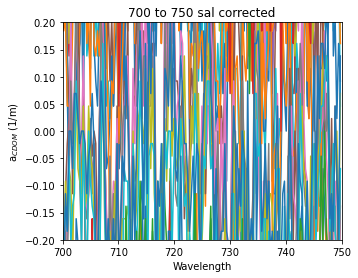

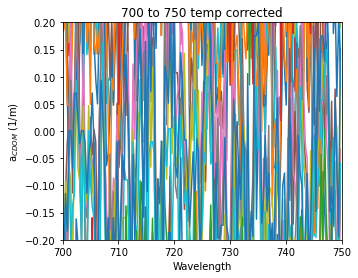

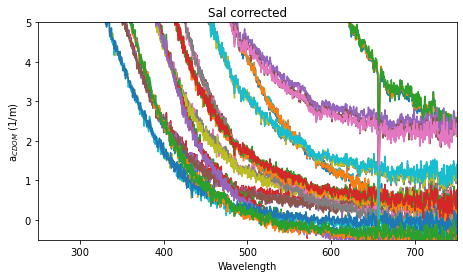

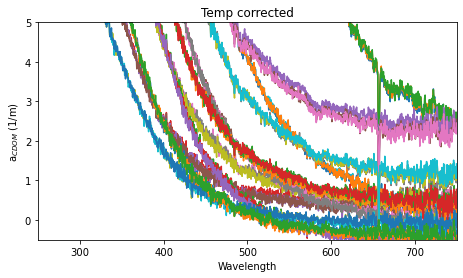

In [13]:
#HERE WE DO THE TEMP CORRECTION FOR ALL THE DATA 
# minimization
#maybe play with bonds for improvement
#minimize(rmse, temp0, df_700.iloc[:,0], bounds=(min,max))

coln = np.arange(0, len(df_700.columns), 1, dtype=int)
Frames = []
frames = []

for col in coln:
    res = minimize(rmse, 0, df_700.iloc[:,col])
    col_ct = temp_cor(res.x, df_cs.iloc[:,col])
    Frames.append(col_ct)
    temp_val = res.x[0]
    col_ct_resid = col_ct[700:750]-col_ct[700:750].mean()
    temp_rmse = np.sqrt(np.mean(col_ct_resid**2))
    dict = {'temp_val':[temp_val], 
           'temp_rmse':[temp_rmse]}
    diff = pd.DataFrame(dict)
    frames.append(diff) #save the inportant outputs 

df_ct = pd.concat(Frames, axis=1, ignore_index=False)
New_Labels = df_cs.columns
df_ct.columns = New_Labels

outputs = pd.concat(frames, axis=0, ignore_index=False)
New_Labels = df_cs.columns
outputs.index = list(New_Labels)

fig, ax = plt.subplots(figsize=(5,4))
df_cs.plot(ax=ax, legend=None)
ax.set_ylim(-.2,.2)
ax.set_xlim(700,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("700 to 750 sal corrected")
#ax.legend()

fig, ax = plt.subplots(figsize=(5,4))
df_ct.plot(ax=ax, legend=None)
ax.set_ylim(-.2,.2)
ax.set_xlim(700,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("700 to 750 temp corrected")
#ax.legend()

fig, ax = plt.subplots(figsize=(7.5,4))
df_cs.plot(ax=ax, legend=None)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("Sal corrected")
#ax.legend()

fig, ax = plt.subplots(figsize=(7.5,4))
df_ct.plot(ax=ax, legend=None)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("Temp corrected")
#ax.legend()

print("")
temp_corr_per = ((df_cs.mean().mean()-df_ct.mean().mean())/(df_cs.mean().mean()+df_ct.mean().mean())/2)*100
print(temp_corr_per, "% differance in mean values")
print("")

temp_cuttoff = 30
max_temp = outputs["temp_val"].max()
temp_cout = abs(outputs["temp_val"]).gt(30).sum()
rmse_cutoff = 10
max_rmse = outputs["temp_rmse"].max()
rmse_cout = outputs["temp_rmse"].gt(rmse_cutoff).sum()

if max_rmse > rmse_cutoff: 
    print("WARNING")
    print("RMSE PROBLEM")
    print("")
    print("max rmse:", max_rmse)
    print("rmse cuttoff:", rmse_cutoff)
    print(rmse_cout, 'fits were above the cuttoff')
    print("Min val of sal Corr:",df_cs.min().min()) 
    print("Min val of temo Corr:",df_ct.min().min()) 
if max_temp > temp_cuttoff: 
    print("WARNING")
    print("TEMP PROBLEM")
    print("")
    print("max temp:", max_temp)
    print("temp cuttoff:", temp_cuttoff)
    print(temp_cout, 'fits were above the cuttoff')
    print("Min val of sal Corr:",df_cs.min().min()) 
    print("Min val of temo Corr:",df_ct.min().min()) 
else: 
    print('the run was a success! :) ')

### baceline correction

just subtract the mean from 700 to 725


mean value for the baceline: 0.6489316437809498
min value for the baceline: -0.565923425863632
max value for the baceline: 2.9358078514605004

Succcess


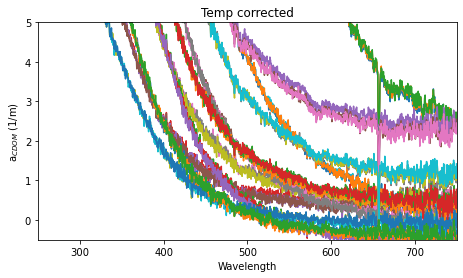

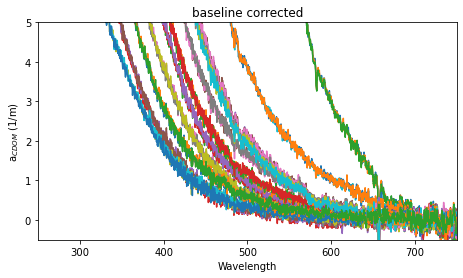

In [14]:
#HERE WE DO THE BASLINE CORRECTION AND SAVE THE CORECTION AS 'bcorr'

bcorr = df_ct[700:725].mean(axis=0) # 486:537 is 675 to 725 nm and this line takes the average 
df_bc = df_ct[:] - bcorr # here we correct the data by that average

fig, ax = plt.subplots(figsize=(7.5,4))
df_ct.plot(ax=ax, legend=None)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("Temp corrected")
#ax.legend()

fig, ax = plt.subplots(figsize=(7.5,4))
df_bc.plot(ax=ax, legend=None)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("baseline corrected")
#ax.legend()

outputs['mean_700_725'] = bcorr
print("")
print("mean value for the baceline:", outputs['mean_700_725'].mean())
print("min value for the baceline:", outputs['mean_700_725'].min())
print("max value for the baceline:", outputs['mean_700_725'].max())
print("")
print("Succcess")

### Compare the data and make a decision

look at the graph 

look at the stats 

decide what to use if you dont like the defauts 

Then we will move into the outputs

here we can compare the diffrent data sets


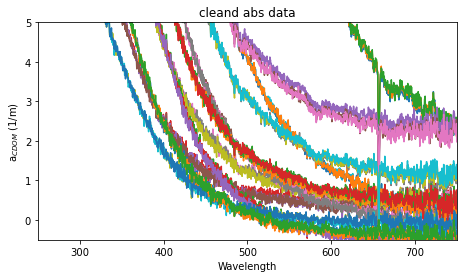

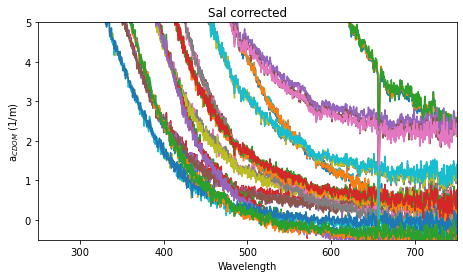

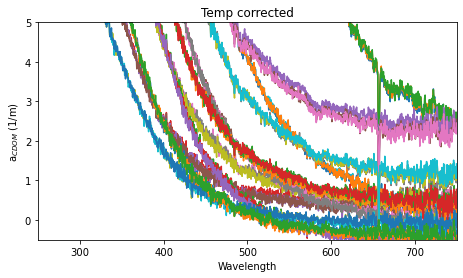

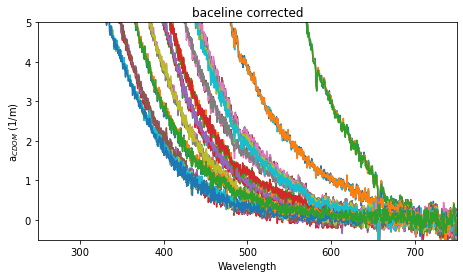

In [15]:
#LOOK AT THE GRAPHS 

fig, ax = plt.subplots(figsize=(7.5,4))
df_cl.plot(ax=ax, legend=None)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("cleand abs data")
#ax.legend()

fig, ax = plt.subplots(figsize=(7.5,4))
df_cs.plot(ax=ax, legend=None)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("Sal corrected")
#ax.legend()

fig, ax = plt.subplots(figsize=(7.5,4))
df_ct.plot(ax=ax, legend=None)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("Temp corrected")
#ax.legend()

fig, ax = plt.subplots(figsize=(7.5,4))
df_bc.plot(ax=ax, legend=None)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("baceline corrected")
#ax.legend()

print("here we can compare the diffrent data sets")

In [16]:
#NOW WE CAN TAKE A LOOK AT SOME STATS 

abs_254_cl = df_cl[254:255].mean(axis=0)
abs_280_cl = df_cl[280:281].mean(axis=0)
abs_320_cl = df_cl[320:321].mean(axis=0)
abs_350_cl = df_cl[350:351].mean(axis=0)
abs_412_cl = df_cl[412:413].mean(axis=0)
abs_440_cl = df_cl[440:441].mean(axis=0)
abs_500_cl = df_cl[500:501].mean(axis=0)
abs_600_cl = df_cl[600:601].mean(axis=0)

abs_254_cs = df_cs[254:255].mean(axis=0)
abs_280_cs = df_cs[280:281].mean(axis=0)
abs_320_cs = df_cs[320:321].mean(axis=0)
abs_350_cs = df_cs[350:351].mean(axis=0)
abs_412_cs = df_cs[412:413].mean(axis=0)
abs_440_cs = df_cs[440:441].mean(axis=0)
abs_500_cs = df_cs[500:501].mean(axis=0)
abs_600_cs = df_cs[600:601].mean(axis=0)

abs_254_ct = df_ct[254:255].mean(axis=0)
abs_280_ct = df_ct[280:281].mean(axis=0)
abs_320_ct = df_ct[320:321].mean(axis=0)
abs_350_ct = df_ct[350:351].mean(axis=0)
abs_412_ct = df_ct[412:413].mean(axis=0)
abs_440_ct = df_ct[440:441].mean(axis=0)
abs_500_ct = df_ct[500:501].mean(axis=0)
abs_600_ct = df_ct[600:601].mean(axis=0)

abs_254_bc = df_bc[254:255].mean(axis=0)
abs_280_bc = df_bc[280:281].mean(axis=0)
abs_320_bc = df_bc[320:321].mean(axis=0)
abs_350_bc = df_bc[350:351].mean(axis=0)
abs_412_bc = df_bc[412:413].mean(axis=0)
abs_440_bc = df_bc[440:441].mean(axis=0)
abs_500_bc = df_bc[500:501].mean(axis=0)
abs_600_bc = df_bc[600:601].mean(axis=0)

d = {'abs_254': abs_254_cl}
stats_data_cl = pd.DataFrame(d, index = df_bc.columns)
stats_data_cl['abs_280'] = abs_280_cl
stats_data_cl['abs_320'] = abs_320_cl
stats_data_cl['abs_350'] = abs_350_cl
stats_data_cl['abs_412'] = abs_412_cl
stats_data_cl['abs_440'] = abs_440_cl
stats_data_cl['abs_500'] = abs_500_cl
stats_data_cl['abs_600'] = abs_600_cl

d = {'abs_254': abs_254_cs}
stats_data_cs = pd.DataFrame(d, index = df_bc.columns)
stats_data_cs['abs_280'] = abs_280_cs
stats_data_cs['abs_320'] = abs_320_cs
stats_data_cs['abs_350'] = abs_350_cs
stats_data_cs['abs_412'] = abs_412_cs
stats_data_cs['abs_440'] = abs_440_cs
stats_data_cs['abs_500'] = abs_500_cs
stats_data_cs['abs_600'] = abs_600_cs

d = {'abs_254': abs_254_ct}
stats_data_ct = pd.DataFrame(d, index = df_bc.columns)
stats_data_ct['abs_280'] = abs_280_ct
stats_data_ct['abs_320'] = abs_320_ct
stats_data_ct['abs_350'] = abs_350_ct
stats_data_ct['abs_412'] = abs_412_ct
stats_data_ct['abs_440'] = abs_440_ct
stats_data_ct['abs_500'] = abs_500_ct
stats_data_ct['abs_600'] = abs_600_ct

d = {'abs_254': abs_254_bc}
stats_data_bc = pd.DataFrame(d, index = df_bc.columns)
stats_data_bc['abs_280'] = abs_280_bc
stats_data_bc['abs_320'] = abs_320_bc
stats_data_bc['abs_350'] = abs_350_bc
stats_data_bc['abs_412'] = abs_412_bc
stats_data_bc['abs_440'] = abs_440_bc
stats_data_bc['abs_500'] = abs_500_bc
stats_data_bc['abs_600'] = abs_600_bc

Clean = stats_data_cl.lt(0).sum()
Sal_cor = stats_data_cs.lt(0).sum()
Temp_cor = stats_data_ct.lt(0).sum()
Baceline_corr = stats_data_bc.lt(0).sum()

d = {'Clean': Clean, 
    'Sal_cor': Sal_cor, 
    'Temp_cor': Temp_cor,
    'Baceline_corr': Baceline_corr}
stat_data = pd.DataFrame(d, index = Clean.index)

min_1 = stat_data['Clean'].sum()
min_2 = stat_data['Sal_cor'].sum()
min_3 = stat_data['Temp_cor'].sum()
min_4 = stat_data['Baceline_corr'].sum()

stat_data.loc["Total"] = stat_data.sum()
min_neg_count_val = stat_data.loc["Total"].min()

if min_neg_count_val > (len(df_cl.columns)*8)/2:
    print("!!!!! WARNING !!!!! SHIT HAS GONE BAD !!!!!!")
    print("Over half of it is bad")
    print("you have", min_1, "bad values out of", len(df_cl.columns)*8) 
    print("look at the data")
    print("")
    print(stat_data)
if min_4 == min_neg_count_val and min_4 != min_3: 
    print("use: df_bc")
    print("bad values:", min_4)
    print("% values:", min_4/(len(df_cl.columns)*8)*100)
    print("")
    print(Baceline_corr)
    df_final = df_bc
    col_note_1 = "baceline corrected"
if min_3 == min_neg_count_val and min_3 != min_2:
    print("use: df_ct")
    print("bad values:", min_3)
    print("% values:", min_3/(len(df_cl.columns)*8)*100)
    print("")
    print(Temp_cor)
    df_final = df_ct
    col_note_1 = "temp and sal corrected"
if min_2 == min_neg_count_val and min_2 != min_1:
    print("use: df_cs")
    print("bad values:", min_2)
    print("% values:", min_2/(len(df_cl.columns)*8)*100)
    print("")
    print(Sal_cor)
    df_final = df_cs
    col_note_1 = "sal corrected"
if min_1 == min_neg_count_val:
    print("use: df_cl")
    print("bad values:", min_1)
    print("% values:", min_1/(len(df_cl.columns)*8)*100)
    print("")
    print(Clean)
    df_final = df_cl
    col_note_1 = "no corrections"
if min_4 == min_3 and min_3 <= min_neg_count_val:
    print("")
    print('NOTE: bacline corr and temp core are the same')
    print("")
    print(stat_data)
if min_3 == min_2 and min_2 <= min_neg_count_val:
    print("")
    print('NOTE: temp corr and sal core are the same')
    print("")
    print(stat_data)
if min_2 == min_1 and min_1 <= min_neg_count_val:
    print("")
    print('NOTE: sal corr and clean core are the same')
    print("")
    print(stat_data)
else: 
    print(stat_data)

use: df_bc
bad values: 3
% values: 1.1363636363636365

abs_254    0
abs_280    0
abs_320    0
abs_350    0
abs_412    0
abs_440    0
abs_500    0
abs_600    3
dtype: int64
         Clean  Sal_cor  Temp_cor  Baceline_corr
abs_254      0        0         0              0
abs_280      0        0         0              0
abs_320      0        0         0              0
abs_350      0        0         0              0
abs_412      0        0         0              0
abs_440      0        0         0              0
abs_500      0        0         0              0
abs_600      9        9         9              3
Total        9        9         9              3


In [17]:
#OVERRIDE 
df_final = df_cl
df_final

,227121_01,227121_02,227121_03,227122_01,227122_02,227122_03,227123_01,227123_02,227123_03,227125_01,...,227103_03,227104_01,227104_02,227104_03,227105_01,227105_02,227105_03,227106_01,227106_02,227106_03
wl,,,,,,,,,,,,,,,,,,,,,
189.662,-137.16668,-165.70085,79.36138,-0.00000,-86.68492,-82.35528,-0.00000,-108.77069,-106.37557,-0.00000,...,-0.00000,-101.95381,-0.00000,-57.62106,-72.31420,-89.86306,-25.28694,-142.23328,-0.00000,-0.00000
190.044,-137.16668,-165.70085,79.36138,-0.00000,-86.68492,-82.35528,-0.00000,-108.77069,-106.37557,-0.00000,...,-0.00000,-101.95381,-0.00000,-57.62106,-72.31420,-89.86306,-25.28694,-142.23328,-0.00000,-0.00000
190.426,-180.83156,-0.00000,-0.00000,-178.18311,-191.33324,-383.91010,-0.00000,-132.16917,-0.00000,-0.00000,...,97.73932,-0.00000,19.34520,91.88970,208.19120,-0.00000,54.09747,320.76184,209.57300,26.34632
190.809,64.34582,65.19793,160.51910,-65.54338,75.33113,263.46320,-0.00000,84.22071,15.38404,67.82335,...,48.75451,-0.00000,-0.00000,138.50242,87.42188,-9.46533,109.92219,-0.00000,25.40209,-0.00000
191.191,89.37943,-99.65081,-0.00000,51.58720,-0.00000,25.47118,-138.08788,18.47006,-0.00000,-0.00000,...,214.93899,236.14962,26.41541,-54.74231,-0.00000,-22.79970,-17.24947,-42.95095,-0.00000,-0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880.598,5.59629,4.44479,4.76721,1.22059,0.62181,1.31271,1.42786,2.44118,0.27636,0.11515,...,4.58297,6.83991,5.02054,4.49085,6.47143,6.17204,4.95145,4.12237,0.73696,4.60600
880.888,2.09573,8.01444,3.33935,0.75999,-0.57575,2.74057,2.87875,3.68480,4.09934,0.52969,...,1.35877,3.10905,7.69202,6.74779,5.36599,3.66177,1.79634,1.61210,1.22059,1.70422
881.179,4.30661,0.62181,1.98058,-3.15511,2.51027,-1.65816,-0.99029,0.80605,-1.56604,-1.40483,...,3.79995,2.99390,2.09573,6.65567,4.35267,2.60239,2.83269,2.23391,-0.73696,2.41815


PART 2: REGRESSIONS

I need an output table for each sampling event with the sample number

we will get this with 2 regression methods 

there are two ways we are going to calculate the spectral slopes 
1. Single exponential (SEM) where: $A(g)=Ae^{slope}$
2. Hyperbolic (HM) where: $A(g)=A(\frac{wl}{532})^{slope}$
2. Power Law (PL) where:

corresponding parameters - slopes 
                the spectral slope of 275 to 295
                the spectral slope of 350 to 400
                the spectral slope of 275 to 700

corresponding parameters - slop ratios
                spectral ratio of slope 275 to 295 to slope of 350 to 400


In [18]:
#DEFINE EXPONENTAL REGRESSION 
#A(g)=Ae^slope
def exp_equation(x, a, s, b):
    return a * np.exp(-s * x) + b

#DEFINE HYPERBOLIC REGRESSION 
#A(g)=A(wl/532)^slope
def hyp_equation(x, a, s, b):
    return a * ((x/532)**-s) + b

#DEFINE POWER LAW REGRESSION 
#going to do that in the future 

#add a wl col so we can use it in the rags  
df_final["wl"] = df_final.index

print("the functions are set")

the functions are set


In [19]:
#HERE DO THE EXPONENTAL REGRESSION FOR ALL SAMPLES 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df_final.iteritems():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df_final[(df_final['wl']>=275) & (df_final['wl']<=700)][col]
    xdata_s700 = df_final[(df_final['wl']>=275) & (df_final['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df_final[(df_final['wl']>=275) & (df_final['wl']<=295)][col]
    xdata_s295 = df_final[(df_final['wl']>=275) & (df_final['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df_final[(df_final['wl']>=350) & (df_final['wl']<=400)][col]
    xdata_s350 = df_final[(df_final['wl']>=350) & (df_final['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (15, .001, 0)
    pams_295 = (10, .001, 0)
    pams_350 = (10, .001, 0)
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(exp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - exp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = exp_equation(252, a, s, b)
    abs_280 = exp_equation(280, a, s, b)
    abs_320 = exp_equation(320, a, s, b)
    abs_350 = exp_equation(350, a, s, b)
    abs_412 = exp_equation(412, a, s, b)
    abs_440 = exp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(exp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - exp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(exp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - exp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_sem':[ss_275_700],
        'ss_275_295_sem':[ss_275_295],
        'ss_350_400_sem':[ss_350_400],
        'R2_275_700_sem':[R2_275_700],
        'R2_275_295_sem':[R2_275_295],
        'R2_350_400_sem':[R2_350_400],
        'SR_sem':[sr]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs_sem = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs_sem = ss_outs_sem.drop('wl')

print("Single exponential done! yay!")

Single exponential done! yay!


In [20]:
#HERE DO THE HYPERBOLIC REGRESSION FOR ALL SAMPLES 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df_final.iteritems():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df_final[(df_final['wl']>=275) & (df_final['wl']<=700)][col]
    xdata_s700 = df_final[(df_final['wl']>=275) & (df_final['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df_final[(df_final['wl']>=275) & (df_final['wl']<=295)][col]
    xdata_s295 = df_final[(df_final['wl']>=275) & (df_final['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df_final[(df_final['wl']>=350) & (df_final['wl']<=400)][col]
    xdata_s350 = df_final[(df_final['wl']>=350) & (df_final['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (.001, 11, 0)
    pams_295 = (1, 0, 1)
    pams_350 = (1, 1, 1)
    
    maxfev = 1000000
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(hyp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - hyp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = hyp_equation(252, a, s, b)
    abs_280 = hyp_equation(280, a, s, b)
    abs_320 = hyp_equation(320, a, s, b)
    abs_350 = hyp_equation(350, a, s, b)
    abs_412 = hyp_equation(412, a, s, b)
    abs_440 = hyp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(hyp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - hyp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(hyp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - hyp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_hm':[ss_275_700],
        'ss_275_295_hm':[ss_275_295],
        'ss_350_400_hm':[ss_350_400],
        'R2_275_700_hm':[R2_275_700],
        'R2_275_295_hm':[R2_275_295],
        'R2_350_400_hm':[R2_350_400],
        'SR_hm':[sr]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs_hm = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs_hm = ss_outs_hm.drop('wl')

print("Single exponential done! yay!")

Single exponential done! yay!


In [21]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where

#make the outputs an easy to use data frame 
ss_outs = pd.concat([ss_outs_sem, ss_outs_hm, outputs], axis = 1, ignore_index=False)

#set the R2 level you want 
R_level = .95
col_note_2 = f'R sqared cuttoff: {R_level}'
col_note_2

#print out the summary stats 
min_1 = ss_outs['R2_275_700_sem'].min()
min_2 = ss_outs['R2_275_295_sem'].min()
min_3 = ss_outs['R2_350_400_sem'].min()
min_4 = ss_outs['R2_275_700_hm'].min()
min_5 = ss_outs['R2_275_295_hm'].min()
min_6 = ss_outs['R2_350_400_hm'].min()

filter_col = [col for col in ss_outs if col.startswith('R2')]

if 1 < 2:
    print("")
    print("the R2 cuttoff was", R_level)
if min_1 < R_level: 
    print("")
    print("bad fits in Exponential 275 to 700:", ss_outs["R2_275_700_sem"].lt(R_level).sum())
if min_2 < R_level:
    print("")
    print("bad fits in Exponential 275 to 275:", ss_outs["R2_275_295_sem"].lt(R_level).sum())
if min_3 < R_level:
    print("")
    print("bad fits in Exponential 350 to 400:", ss_outs["R2_350_400_sem"].lt(R_level).sum())
if min_4 < R_level:
    print("")
    print("bad fits in Hyperbolic 275 to 700:", ss_outs["R2_275_700_hm"].lt(R_level).sum())
if min_5 < R_level:
    print("")
    print("bad fits in Hyperbolic 275 to 275:", ss_outs["R2_275_295_hm"].lt(R_level).sum())
if min_6 < R_level:
    print("")
    print("bad fits in Hyperbolic 350 to 400:", ss_outs["R2_350_400_hm"].lt(R_level).sum())
if ss_outs[filter_col].gt(R_level).sum().sum() > ss_outs[filter_col].lt(R_level).sum().sum():
    print("")
    print(ss_outs[filter_col].gt(R_level).sum().sum(),": fits came out good")
    print(ss_outs[filter_col].lt(R_level).sum().sum(),": fits came out bad")
    print("")
    print("Succsess:", ss_outs[filter_col].gt(R_level).sum().sum()/ss_outs[filter_col].gt(-1000).sum().sum()*100,"%" )
else: 
    print("")
    print("SOMETHING HAS GONE WRONG")
    print("")
    print("fits came out good")
    print(ss_outs[filter_col].gt(R_level).sum())
    print("TOTAL GOOD:", ss_outs[filter_col].gt(R_level).sum().sum())
    print("")
    print("fits came out bad")
    print(ss_outs[filter_col].lt(R_level).sum())
    print("TOTAL BAD:", ss_outs[filter_col].lt(R_level).sum().sum())



the R2 cuttoff was 0.95

198 : fits came out good
0 : fits came out bad

Succsess: 100.0 %


In [22]:
#ONCE YOU ARE HAPPY WITH THE CUTTOFFS CLEAN IT UP 
#clean the data set baced on the paramiters we set 
outputs_cl = ss_outs

outputs_cl.loc[ss_outs.R2_275_700_sem < R_level, 'ss_275_700_sem'] = np.nan
outputs_cl.loc[ss_outs.R2_275_295_sem < R_level, 'ss_275_295_sem'] = np.nan
outputs_cl.loc[ss_outs.R2_350_400_sem < R_level, 'ss_350_400_sem'] = np.nan
outputs_cl.loc[ss_outs.R2_275_295_sem < R_level, 'SR_sem'] = np.nan
outputs_cl.loc[ss_outs.R2_350_400_sem < R_level, 'SR_sem'] = np.nan
outputs_cl.loc[ss_outs.R2_275_700_hm < R_level, 'ss_275_700_hm'] = np.nan
outputs_cl.loc[ss_outs.R2_275_295_hm < R_level, 'ss_275_295_hm'] = np.nan
outputs_cl.loc[ss_outs.R2_350_400_hm < R_level, 'ss_350_400_hm'] = np.nan
outputs_cl.loc[ss_outs.R2_275_295_hm < R_level, 'SR_hm'] = np.nan
outputs_cl.loc[ss_outs.R2_350_400_hm < R_level, 'SR_hm'] = np.nan

outs = outputs_cl.drop('R2_275_700_sem', axis = 1)
outs = outs.drop('R2_275_295_sem', axis = 1)
outs = outs.drop('R2_350_400_sem', axis = 1)
outs = outs.drop('R2_275_700_hm', axis = 1)
outs = outs.drop('R2_275_295_hm', axis = 1)
outs = outs.drop('R2_350_400_hm', axis = 1)
print("data is cleaned up")

data is cleaned up


MAKE THE FINAL PRODUCTS AND EXPORT 

corresponding parameters - cdom abs  

the cdom abd at 254

the cdom abd at 320

the cdom abd at 350

the cdom abd at 412

the cdom abd at 440 

the cdom abd at 700

the interproated data set for each scan is created
the mean data set for each sample is created
the transpose data set is created
see the graphs


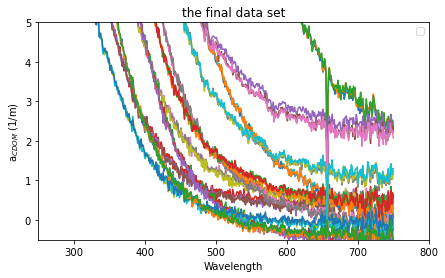

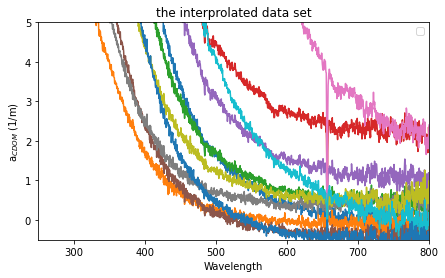

In [23]:
#HERE WE MAKE A COPY INTERPROLATED DATA SET
x = df_final.index
coln = np.arange(0, len(df_final.columns), 1, dtype=int)

Frames = []
frames = []

for col in coln:
    y = df_final.iloc[:,col]
    pchip_col = PchipInterpolator(x, y, axis=1)
    xi = np.arange(250,751,1)
    yi = pchip_col(xi)
    d = {'abs': yi}
    pchip_c = pd.DataFrame(d, index = xi)
    Frames.append(pchip_c)

df_pchip = pd.concat(Frames, axis=1, ignore_index=False)
New_Labels = df_final.columns
df_pchip.columns = New_Labels
print("the interproated data set for each scan is created")

#HERE WE MAKE A MEAN DATA SET FOR EACH SAMPLE
names = [name[0] for name in df_pchip.columns.str.rsplit('_')]
df_mean = df_final.groupby(names, axis=1).mean()
df_mean
print("the mean data set for each sample is created")

#HERE WE MAKE A COPY OF THE DATA THAT IS VERTICAL SO JB LIKES IT
abs_data = df_mean.transpose(copy=False)
print("the transpose data set is created")

fig, ax = plt.subplots(figsize=(7,4))
df_pchip.plot(label='', ax=ax)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("the final data set")
ax.legend("")

fig, ax = plt.subplots(figsize=(7,4))
df_mean.plot(label='', ax=ax)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("the interprolated data set")
ax.legend("")

print("see the graphs")

In [24]:
#LETS ADD THOSE IMPORTANT WAVELEGNTHS TO THE OUTOUTS TABEL 

abs_254 = df_pchip.iloc[4:5,]
abs_254 = abs_254.transpose(copy=False)
abs_320 = df_pchip.iloc[70:71,]
abs_320 = abs_320.transpose(copy=False)
abs_350 = df_pchip.iloc[100:101,]
abs_350 = abs_350.transpose(copy=False)
abs_412 = df_pchip.iloc[162:163,]
abs_412 = abs_412.transpose(copy=False)
abs_440 = df_pchip.iloc[190:191,]
abs_440 = abs_440.transpose(copy=False)
abs_700 = df_pchip.iloc[450:451,]
abs_700 = abs_700.transpose(copy=False)


abs_out = pd.concat([abs_254, abs_320, abs_350, abs_412, abs_440, abs_700], axis=1)
New_Labels = {'acdom254','acdom320','acdom350','acdom412','acdom440','acdom700'}
abs_out.columns = New_Labels
outputs_scan = pd.concat([abs_out, outs], axis = 1)
outputs_scan = outputs_scan.drop('wl')

print("Yay! we have the final outputs")

Yay! we have the final outputs


there were 0 scanns output vals that were bad

the blue is the mean
the red is the scanns
make sure nothing is too messes up



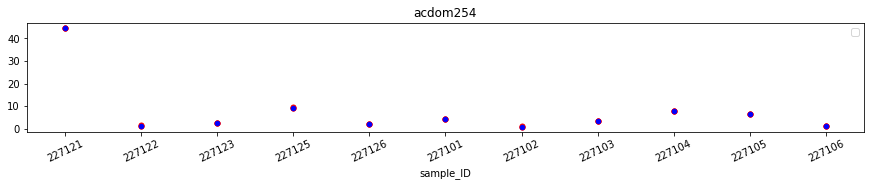

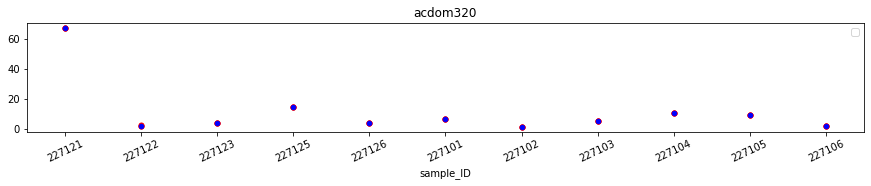

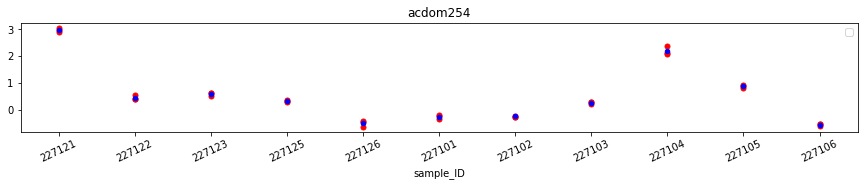

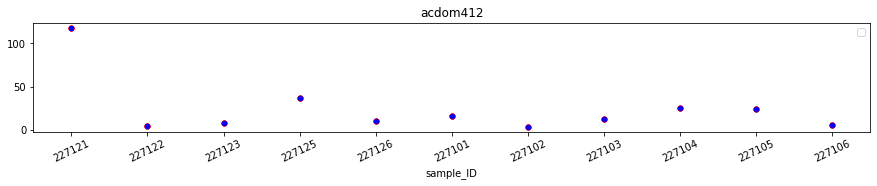

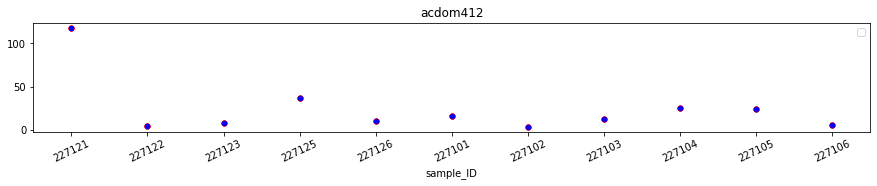

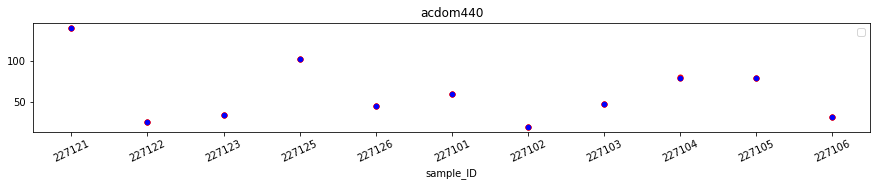

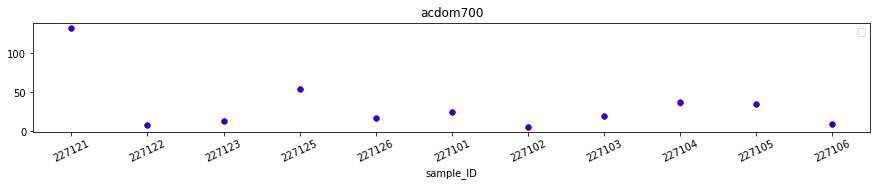

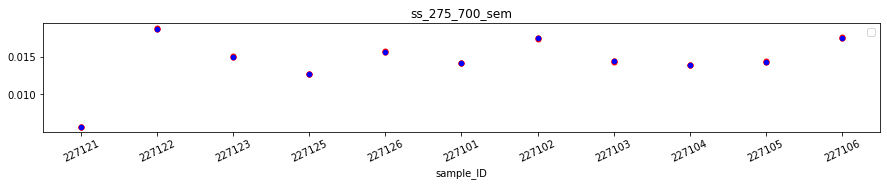

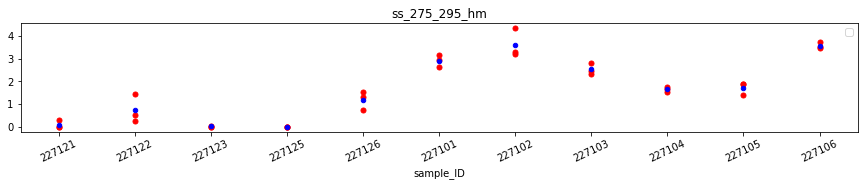

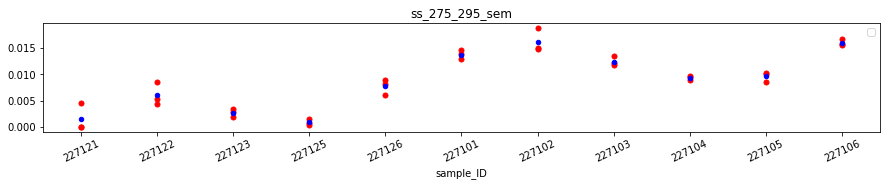

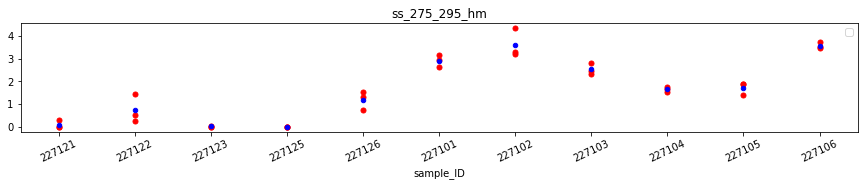

In [25]:
#NOW LETS TEST THE AVERAGEING

stats_sums = outputs_scan.describe()

names = [name[0] for name in outputs_scan.index.str.rsplit('_')]

var = 1.5

z = outputs_scan.groupby(names, 
                        axis = 0).transform(lambda grp: (grp - grp.mean())/grp.std())

test = z.abs().mean(skipna=True)<var
test = test[test==False] # Just print the bad ones

# DROP THE BAD FILES!!!!
outputs_scan_drop = outputs_scan.drop(columns=test.index) # drop bad scans

#test 
off_ave = len(outputs_scan.columns) - len(outputs_scan_drop.columns)

print("there were", off_ave, "scanns output vals that were bad")

if off_ave > 0: 
    print("WARNING")
    print("something went wrong")
    print(stats_sums)

names = [name[0] for name in outputs_scan.index.str.rsplit('_')]
outputs_final = outputs_scan.groupby(names, axis=0).mean()
outputs_final

outputs_final['x1'] = outputs_final.index
outputs_scan['x1'] = names

fig, ax = plt.subplots(figsize=(15,2))
outputs_scan.plot(kind = 'scatter', x = 'x1', y = 'acdom254', ax=ax, c = 'red', s = 25)
outputs_final.plot(kind = 'scatter', x = 'x1', y = 'acdom254', ax=ax, c = 'blue')
ax.set_ylabel("")
ax.set_xlabel("sample_ID")
plt.xticks(rotation = 25)
ax.set_title("acdom254")
ax.legend("")

fig, ax = plt.subplots(figsize=(15,2))
outputs_scan.plot(kind = 'scatter', x = 'x1', y = 'acdom320', ax=ax, c = 'red', s = 25)
outputs_final.plot(kind = 'scatter', x = 'x1', y = 'acdom320', ax=ax, c = 'blue')
ax.set_ylabel("")
ax.set_xlabel("sample_ID")
plt.xticks(rotation = 25)
ax.set_title("acdom320")
ax.legend("")

fig, ax = plt.subplots(figsize=(15,2))
outputs_scan.plot(kind = 'scatter', x = 'x1', y = 'acdom350', ax=ax, c = 'red', s = 25)
outputs_final.plot(kind = 'scatter', x = 'x1', y = 'acdom350', ax=ax, c = 'blue')
ax.set_ylabel("")
ax.set_xlabel("sample_ID")
plt.xticks(rotation = 25)
ax.set_title("acdom254")
ax.legend("")

fig, ax = plt.subplots(figsize=(15,2))
outputs_scan.plot(kind = 'scatter', x = 'x1', y = 'acdom412', ax=ax, c = 'red', s = 25)
outputs_final.plot(kind = 'scatter', x = 'x1', y = 'acdom412', ax=ax, c = 'blue')
ax.set_ylabel("")
ax.set_xlabel("sample_ID")
plt.xticks(rotation = 25)
ax.set_title("acdom412")
ax.legend("")

fig, ax = plt.subplots(figsize=(15,2))
outputs_scan.plot(kind = 'scatter', x = 'x1', y = 'acdom412', ax=ax, c = 'red', s = 25)
outputs_final.plot(kind = 'scatter', x = 'x1', y = 'acdom412', ax=ax, c = 'blue')
ax.set_ylabel("")
ax.set_xlabel("sample_ID")
plt.xticks(rotation = 25)
ax.set_title("acdom412")
ax.legend("")

fig, ax = plt.subplots(figsize=(15,2))
outputs_scan.plot(kind = 'scatter', x = 'x1', y = 'acdom440', ax=ax, c = 'red', s = 25)
outputs_final.plot(kind = 'scatter', x = 'x1', y = 'acdom440', ax=ax, c = 'blue')
ax.set_ylabel("")
ax.set_xlabel("sample_ID")
plt.xticks(rotation = 25)
ax.set_title("acdom440")
ax.legend("")

fig, ax = plt.subplots(figsize=(15,2))
outputs_scan.plot(kind = 'scatter', x = 'x1', y = 'acdom700', ax=ax, c = 'red', s = 25)
outputs_final.plot(kind = 'scatter', x = 'x1', y = 'acdom700', ax=ax, c = 'blue')
ax.set_ylabel("")
ax.set_xlabel("sample_ID")
plt.xticks(rotation = 25)
ax.set_title("acdom700")
ax.legend("")

fig, ax = plt.subplots(figsize=(15,2))
outputs_scan.plot(kind = 'scatter', x = 'x1', y = 'ss_275_700_sem', ax=ax, c = 'red', s = 25)
outputs_final.plot(kind = 'scatter', x = 'x1', y = 'ss_275_700_sem', ax=ax, c = 'blue')
ax.set_ylabel("")
ax.set_xlabel("sample_ID")
plt.xticks(rotation = 25)
ax.set_title("ss_275_700_sem")
ax.legend("")

fig, ax = plt.subplots(figsize=(15,2))
outputs_scan.plot(kind = 'scatter', x = 'x1', y = 'ss_275_295_hm', ax=ax, c = 'red', s = 25)
outputs_final.plot(kind = 'scatter', x = 'x1', y = 'ss_275_295_hm', ax=ax, c = 'blue')
ax.set_ylabel("")
ax.set_xlabel("sample_ID")
plt.xticks(rotation = 25)
ax.set_title("ss_275_295_hm")
ax.legend("")

fig, ax = plt.subplots(figsize=(15,2))
outputs_scan.plot(kind = 'scatter', x = 'x1', y = 'ss_275_295_sem', ax=ax, c = 'red', s = 25)
outputs_final.plot(kind = 'scatter', x = 'x1', y = 'ss_275_295_sem', ax=ax, c = 'blue')
ax.set_ylabel("")
ax.set_xlabel("sample_ID")
plt.xticks(rotation = 25)
ax.set_title("ss_275_295_sem")
ax.legend("")

fig, ax = plt.subplots(figsize=(15,2))
outputs_scan.plot(kind = 'scatter', x = 'x1', y = 'ss_275_295_hm', ax=ax, c = 'red', s = 25)
outputs_final.plot(kind = 'scatter', x = 'x1', y = 'ss_275_295_hm', ax=ax, c = 'blue')
ax.set_ylabel("")
ax.set_xlabel("sample_ID")
plt.xticks(rotation = 25)
ax.set_title("ss_275_295_hm")
ax.legend("")

outputs_final = outputs_final.drop('x1', axis = 1)
outputs_final['note'] = col_note_1

print("")
print("the blue is the mean")
print("the red is the scanns")
print("make sure nothing is too messes up")
print("")

HERE IS A DELIGHTFULL SUMMARY OF THE RUN

0 sample scanns were removed
interprolated correction for sal and temp mean 94.01261454306184 %

SAL CORRECTION
the PSU value was: 0
Min val of clean data: -383.9101
Min val of salinity Corr: -1.05938
4.8872391632275525 % differance in mean values for clean to sal corrected

TEMP FIT MINIMIZE
-0.0048903087271429625 % differance in mean values for the temp optimication
Min val of sal Corr: -1.05938
Min val of temo Corr: -1.0560875380680783
max rmse: 0.2139423907470385
rmse cuttoff: 10
0 fits were above the rmse cuttoff
max temp: 0.41294199607366777
temp cuttoff: 30
0 fits were above the temp cuttoff

BACELINE CORRECTION
mean value for the baceline: 0.6489316437809498
min value for the baceline: -0.565923425863632
max value for the baceline: 2.9358078514605004

CHOOSING A FINAL DATA SET OF CORECTIONS
this time we chose the baceline corrected dataset
         Clean  Sal_cor  Temp_cor  Baceline_corr
abs_254      0        0         0              0


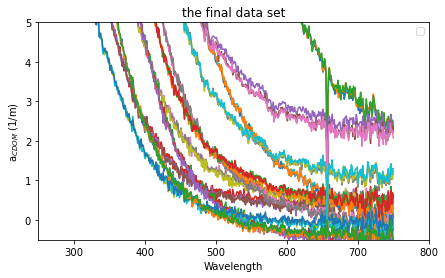

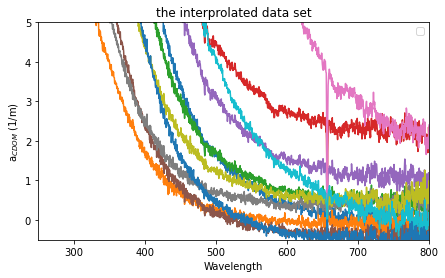

In [26]:
print("HERE IS A DELIGHTFULL SUMMARY OF THE RUN")
print("")
print(rem, "sample scanns were removed")
print('interprolated correction for sal and temp mean',(corr.mean().mean()/correction.mean().mean())*100,'%')
print("")

print("SAL CORRECTION")
print("the PSU value was:", psu)
print("Min val of clean data:",df_cl.min().min()) 
print("Min val of salinity Corr:",df_cs.min().min()) 
print(sal_corr_per, "% differance in mean values for clean to sal corrected")

print("")
print("TEMP FIT MINIMIZE")
print(temp_corr_per, "% differance in mean values for the temp optimication")
print("Min val of sal Corr:",df_cs.min().min()) 
print("Min val of temo Corr:",df_ct.min().min()) 
print("max rmse:", max_rmse)
print("rmse cuttoff:", rmse_cutoff)
print(rmse_cout, 'fits were above the rmse cuttoff')
print("max temp:", max_temp)
print("temp cuttoff:", temp_cuttoff)
print(temp_cout, 'fits were above the temp cuttoff')

if max_rmse > rmse_cutoff: 
    print("WARNING")
    print("RMSE PROBLEM")
if max_temp > temp_cuttoff: 
    print("WARNING")
    print("TEMP PROBLEM")
else: 
    print('')
    
print("BACELINE CORRECTION")
print("mean value for the baceline:", outputs['mean_700_725'].mean())
print("min value for the baceline:", outputs['mean_700_725'].min())
print("max value for the baceline:", outputs['mean_700_725'].max())

print('')
print("CHOOSING A FINAL DATA SET OF CORECTIONS")
print("this time we chose the", col_note_1, 'dataset')
print(stat_data)
print('')

print("THE REGRESSIONS")
print("the R2 cuttoff was", R_level)
print("bad fits in Exponential 275 to 700:", ss_outs["R2_275_700_sem"].lt(R_level).sum())
print("bad fits in Exponential 275 to 275:", ss_outs["R2_275_295_sem"].lt(R_level).sum())
print("bad fits in Exponential 350 to 400:", ss_outs["R2_350_400_sem"].lt(R_level).sum())
print("bad fits in Hyperbolic 275 to 700:", ss_outs["R2_275_700_hm"].lt(R_level).sum())
print("bad fits in Hyperbolic 275 to 275:", ss_outs["R2_275_295_hm"].lt(R_level).sum())
print("bad fits in Hyperbolic 350 to 400:", ss_outs["R2_350_400_hm"].lt(R_level).sum())
print("fits that came out good:",ss_outs[filter_col].gt(R_level).sum().sum())
print("fits that came out bad:",ss_outs[filter_col].lt(R_level).sum().sum())
print("Succsess rate of:", ss_outs[filter_col].gt(R_level).sum().sum()/ss_outs[filter_col].gt(-1000).sum().sum()*100,"%" )
print("bad fits were removed")
print("")

print("AVERAGING THE OUTPUTS")
print("there were", off_ave, "scanns output vals that were bad")
if off_ave > 1: 
    print("WARNING")
    print("something went wrong")
    print(stats_sums)

fig, ax = plt.subplots(figsize=(7,4))
df_pchip.plot(label='', ax=ax)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("the final data set")
ax.legend("")

fig, ax = plt.subplots(figsize=(7,4))
df_mean.plot(label='', ax=ax)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("the interprolated data set")
ax.legend("")

In [27]:
#OK, LETS SAVE WHAT WE WANT 

#save the p chip spectra
abs_data = abs_data.drop('wl', axis = 0)
abs_data.to_csv('../../../IRL22SU/CDOM/2271_IRL_spectra.csv')

#save the outputs chip spectra
outputs_final.to_csv('../../../IRL22SU/CDOM/2271_IRL_outputs.csv')